# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [5]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="lectures_batches", 
                                       batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [6]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={'text':1, 'author':1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [7]:
# Ваш код
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [8]:
model_artm.initialize('dictionary')

In [9]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [10]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [11]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi_1', tau=1e5, dictionary=dictionary,
                                                            class_ids = 'text', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [12]:
# Ваш код
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Wall time: 17.8 s


Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [13]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi_2', tau=-1e5, dictionary=dictionary,
                                                            class_ids = 'text', topic_names=topic_names[:-1]))

Выполните еще 15 проходов по коллекции.

In [14]:
# Ваш код
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Wall time: 8.86 s


##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [15]:
# Ваш код
# выводим топы слов
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:   
        print word,
    print

sbj0:  частица взаимодействие физика энергия кварк симметрия элементарный нейтрино стандартный материя заряд протон масса бозон ускоритель
sbj1:  материал температура структура химический вещество соединение свойство поверхность химия давление углерод сверхпроводимость металл полимер применение
sbj2:  политический государство царь партия власть правитель платон враг сага шмитт государь средневековый египетский демократия египет
sbj3:  знание университет образование школа предмет познание факультет аргумент социологический логика студент кафедра концепт прикладной гумбольдт
sbj4:  мозг нейрон мышление предложение категория лицо корпус чтение конструкция взрослый синтаксический синтаксис словосочетание детство обезьяна
sbj5:  бог миф греческий герой мифология душа грек море мифологический гусейнов божество шумерский персонаж гасан ритуал
sbj6:  русский город городской перевод гласный говор москва пьеса горожанин древнерусский метро цитата издание немецкий житель
sbj7:  трудность раса афр

In [16]:
# выводим топы авторов
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_authors"].last_tokens
    for author in tokens[topic_name]:   
        print author,
    print

sbj0:  Дмитрий_Казаков Михаил_Данилов Виктор_Брагута Павел_Пахлов Сергей_Троицкий Лев_Дудко Лев_Беклемишев Анатолий_Лиходед Эдуард_Боос Игорь_Волобуев Валерий_Рубаков Алексей_Старобинский Сергей_Гашков Дэвид_Гросс Жан-Арыс_Джилкибаев
sbj1:  Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Владимир_Пудалов Иван_Сорокин Валентин_Крапошин Евгений_Гудилин Дмитрий_Гольберг Алексей_Хохлов Дмитрий_Клинов Сергей_Морозов Евгений_Антипов Вадим_Бражкин Алексей_Кавокин
sbj2:  Кирилл_Мартынов Алексей_Юдин Александр_Филиппов Михаил_Бойцов Дина_Гусейнова Александр_Павлов Фёдор_Успенский Андрей_Лукашов Иван_Ладынин Рафаэль_Арутюнян Татьяна_Смоктунович Ольга_Тогоева Дмитрий_Баюк Юрий_Рогулёв Дэвид_Вайнберг
sbj3:  Виктор_Вахштайн Наталья_Ростиславлева Татьяна_Клячко Борис_Миркин Максим_Демин Дмитрий_Балалыкин Ян_Левченко Алексей_Котов Кристофер_Уиншип Дмитрий_Баюк Сергей_Зенкин Максим_Кронгауз Владимир_Миронов Татьяна_Котова Алексей_Руткевич
sbj4:  Филипп_Хайтович Владимир_Спиридонов Надеж

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [17]:
sbj_topic_labels = ['Физика элементарных частиц', 'Структура материалов', "История государств", "Образование", "Развитие мозга",
                    "Мифы древней греции", "История российских городов", "Индейцы", "Залоговое имущество", "Заболевание животных",
                   "Изучение океана", "Зрительное восприятие", "История Руси", "Наука", "Астронимия", "Экономика",
                    "Брак", "Искуственный интелект", "Древние письмена", "Биоинженерия", "Квантовая физика", "Философия", 
                   "История франции", "СССР", "Языки и вера", "Теория относительности", "Театр", "Звезды", "Кино"]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [18]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model_artm.get_phi(class_ids='author')
theta = model_artm.get_theta()
print phi_a.iloc[:5,:6]
print theta.iloc[:5,:2]

                   sbj0  sbj1  sbj2  sbj3  sbj4  sbj5
Ярослав_Исполатов   0.0   0.0   0.0   0.0   0.0   0.0
Сергей_Демокритов   0.0   0.0   0.0   0.0   0.0   0.0
Руслан_Смелянский   0.0   0.0   0.0   0.0   0.0   0.0
Александр_Апт       0.0   0.0   0.0   0.0   0.0   0.0
Людмила_Новикова    0.0   0.0   0.0   0.0   0.0   0.0
      http://postnauka.ru/video/40870  http://postnauka.ru/video/40872
sbj0                     1.985403e-13                     6.558851e-03
sbj1                     2.549763e-07                     2.171860e-10
sbj2                     7.379290e-11                     1.216408e-02
sbj3                     7.365845e-04                     1.200733e-01
sbj4                     8.265564e-03                     0.000000e+00


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

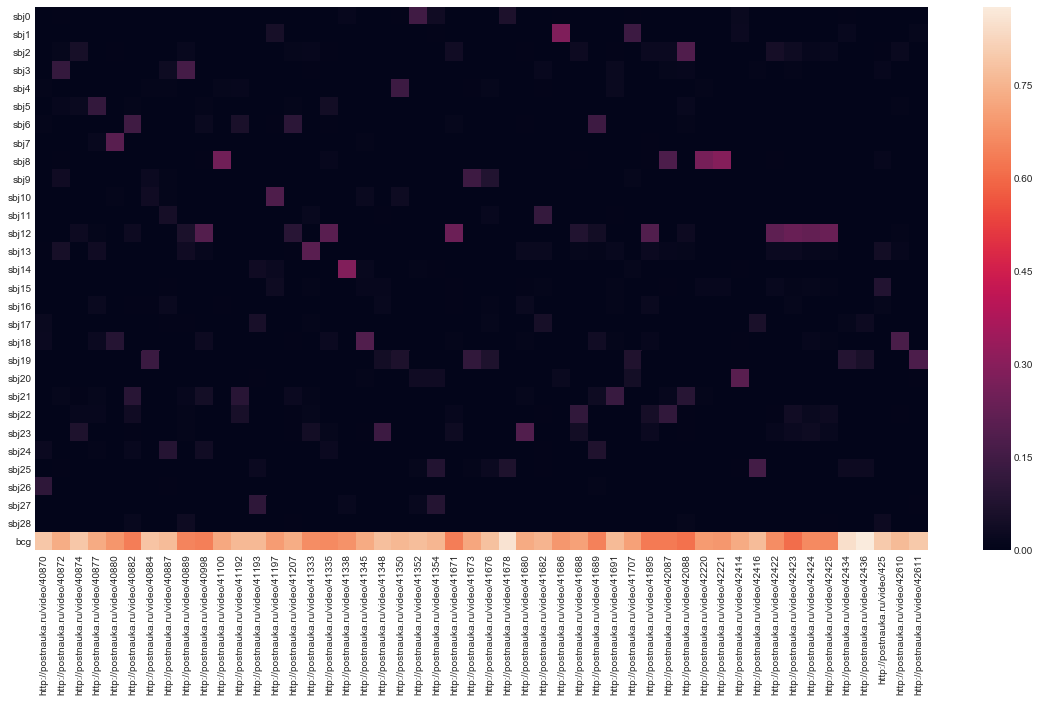

In [19]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(theta.iloc[:,:50])

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [20]:
# Ваш код
df = pd.DataFrame({'p(t)': theta.sum(axis=1).values/theta.shape[1]})

In [21]:
df

,p(t)
0,0.011053
1,0.015128
2,0.009875
3,0.006665
4,0.007202
5,0.007657
6,0.007306
7,0.004611
8,0.009410
9,0.010671


In [22]:
df.nlargest(7, 'p(t)').index

Int64Index([29, 13, 19, 21, 20, 24, 18], dtype='int64')

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [23]:
print '5 самых распространенных тем:\n', "\n".join([str(topic_labels[el]) for el in df.nlargest(7, 'p(t)').index[2:]])

5 самых распространенных тем:
Биоинженерия
Философия
Квантовая физика
Языки и вера
Древние письмена


In [24]:
print '3 наимение распространенных тем:\n', "\n".join([str(topic_labels[el]) for el in df.nsmallest(3, 'p(t)').index])

3 наимение распространенных тем:
Театр
Индейцы
Образование


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

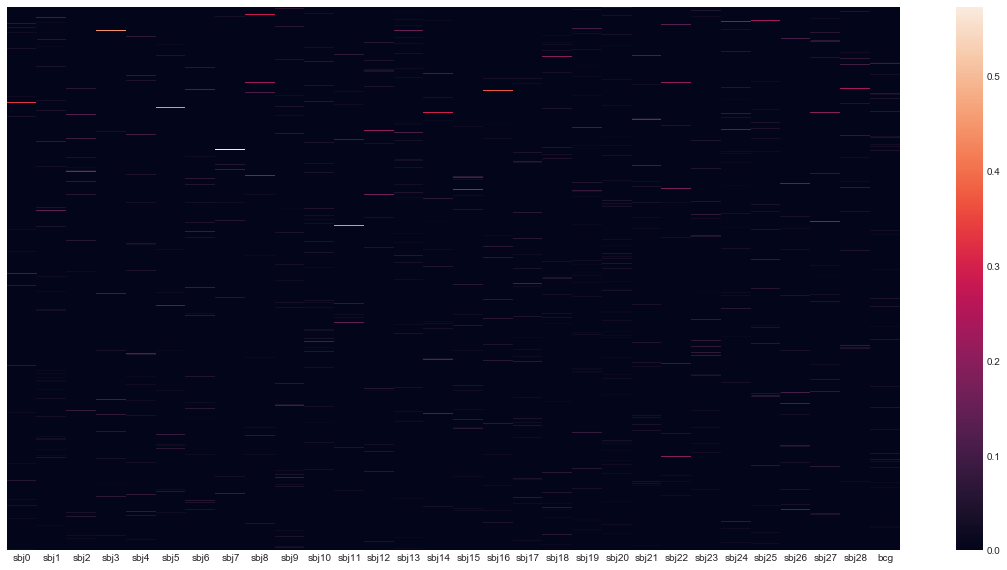

In [25]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [26]:
author = np.sum(phi_a>0.01,axis=1)
print "Ваш ответ:\nавторы, значимые в не менее чем 3 темах:"
print author [author>=3]

Ваш ответ:
авторы, значимые в не менее чем 3 темах:
Александр_Филиппов      3
Дина_Гусейнова          3
Фёдор_Успенский         3
Михаил_Алексеевский     5
Николай_Дронин          3
Ян_Левченко             4
Александр_Воеводский    3
Андрей_Чабовский        3
Павел_Нерлер_(Полян)    3
Ольга_Вайнштейн         3
Андрей_Журавлев         3
Александр_Пиперски      3
dtype: int64


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [27]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [28]:
# Ваш код
them_profs_1 = phi_a.values*df.values.T
them_profs_2 = them_profs_1.sum(axis=1)

them_profs = them_profs_1/them_profs_2.reshape(len(them_profs_2),1)

method_MDS = MDS(n_components=2, metric = 'cosine')

In [29]:
graf = method_MDS.fit_transform(them_profs)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

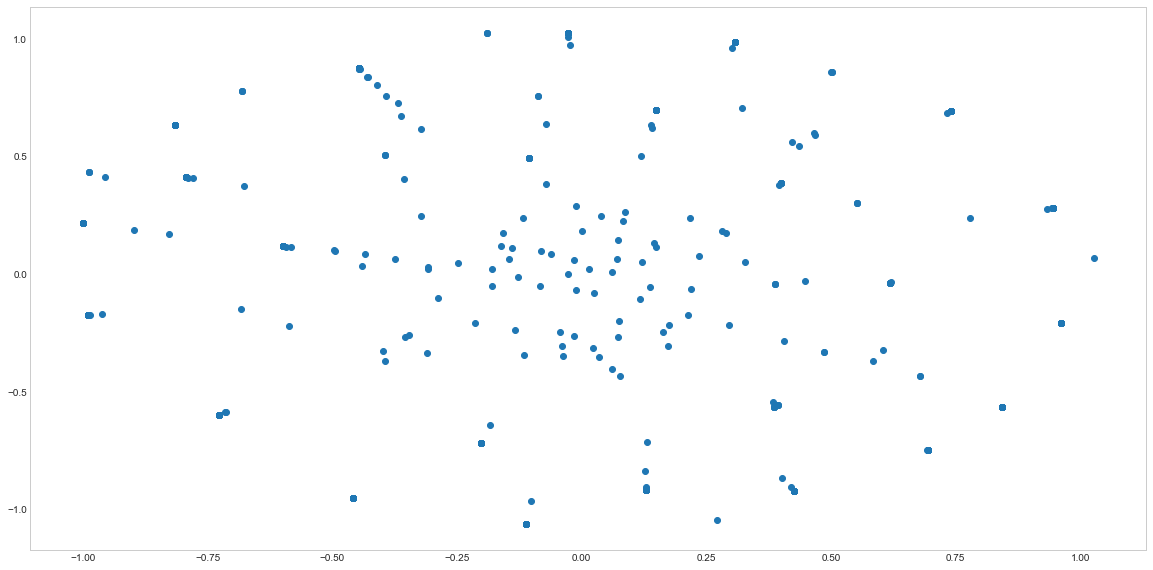

In [30]:
# Ваш код
plt.figure(figsize=(20,10))
plt.scatter(graf[:,0], graf[:,1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [31]:
print them_profs.shape
print np.sum(them_profs !=0)

(539L, 30L)
834


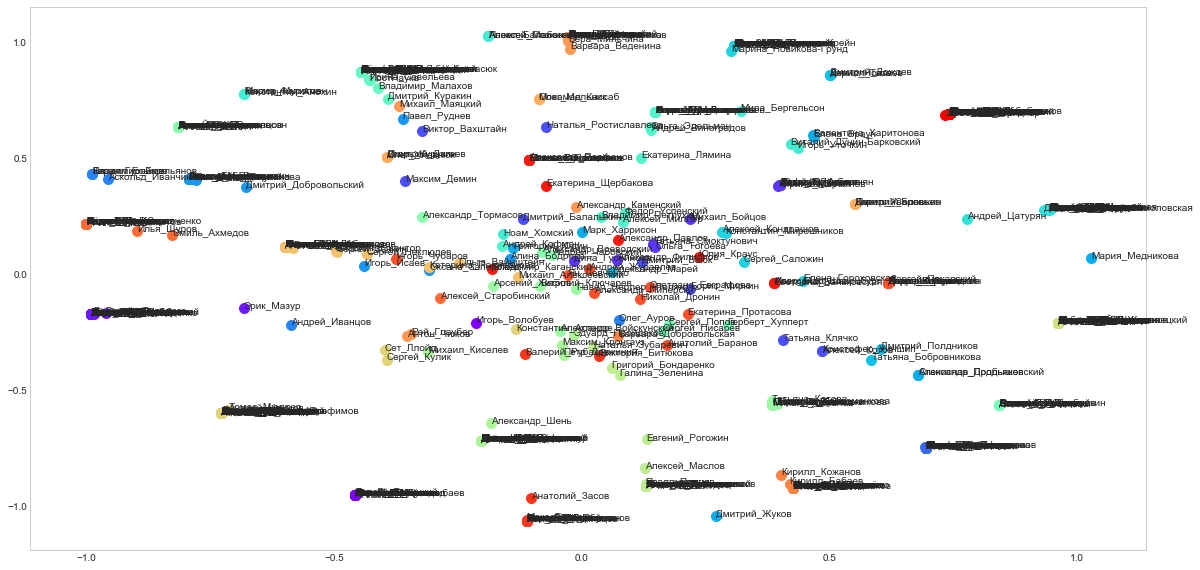

In [32]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
plt.figure(figsize=(20,10))
for i in range(phi_a.shape[0]):
    color = colors[np.argmax(phi_a.iloc[i,:].values)]
    plt.annotate(phi_a.index[i], xy=(graf[i,0], graf[i,1]))
    plt.scatter(graf[i,0], graf[i,1], c=color, s=100, )
plt.savefig('authors.pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [33]:
# Ваш код
pdt = theta.values/theta.values.sum(axis=1).reshape(len(theta),1)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [34]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [35]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [36]:
# Ваш код
for i in range(len(theta)-1):
    print sbj_topic_labels[i]
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[model_artm.topic_names[i]][:10]:   
        print word,
    print
    for them in pdt[i].argsort()[-10:][::-1]:
        print theta.columns[them]
    print '\n'
    


Физика элементарных частиц
частица взаимодействие физика энергия кварк симметрия элементарный нейтрино стандартный материя
http://postnauka.ru/video/18870
http://postnauka.ru/video/13043
http://postnauka.ru/video/2945
http://postnauka.ru/video/53507
http://postnauka.ru/video/14283
http://postnauka.ru/video/18873
http://postnauka.ru/video/47950
http://postnauka.ru/video/18865
http://postnauka.ru/video/10383
http://postnauka.ru/video/47826


Структура материалов
материал температура структура химический вещество соединение свойство поверхность химия давление
http://postnauka.ru/video/13700
http://postnauka.ru/video/11023
http://postnauka.ru/video/13544
http://postnauka.ru/video/31182
http://postnauka.ru/video/10379
http://postnauka.ru/video/9144
http://postnauka.ru/video/18048
http://postnauka.ru/video/57995
http://postnauka.ru/video/48107
http://postnauka.ru/video/41686


История государств
политический государство царь партия власть правитель платон враг сага шмитт
http://postnauka.ru/

http://postnauka.ru/video/19436
http://postnauka.ru/video/10754
http://postnauka.ru/video/5915
http://postnauka.ru/video/13153
http://postnauka.ru/video/11620
http://postnauka.ru/video/10475
http://postnauka.ru/video/7113


Квантовая физика
квантовый поле магнитный электрон свет волна атом фотон эффект физико-математический
http://postnauka.ru/video/24434
http://postnauka.ru/video/25875
http://postnauka.ru/video/26609
http://postnauka.ru/video/14283
http://postnauka.ru/video/3381
http://postnauka.ru/video/13157
http://postnauka.ru/video/11250
http://postnauka.ru/video/21662
http://postnauka.ru/video/19457
http://postnauka.ru/video/15044


Философия
культура философия текст философский литература философ литературный писать автор произведение
http://postnauka.ru/video/2529
http://postnauka.ru/video/2524
http://postnauka.ru/video/23834
http://postnauka.ru/video/53513
http://postnauka.ru/video/37965
http://postnauka.ru/video/32664
http://postnauka.ru/video/12738
http://postnauka.ru/video/

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 